#### Inicialização de variáveis e importação de bibliotecas

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input
from keras.preprocessing.image import load_img, img_to_array


AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 180
img_width = 180
data_dir='data/cuted/'

2024-04-12 15:06:20.648481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 15:06:20.649687: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 15:06:20.703413: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 15:06:20.952067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:06:21.930101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1706 files belonging to 2 classes.
Using 1365 files for training.


Found 1706 files belonging to 2 classes.
Using 341 files for validation.


2024-04-12 15:06:23.572704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-12 15:06:23.573072: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
class_names = train_ds.class_names
print(class_names)

['header', 'non-header']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-12 15:06:26.285229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


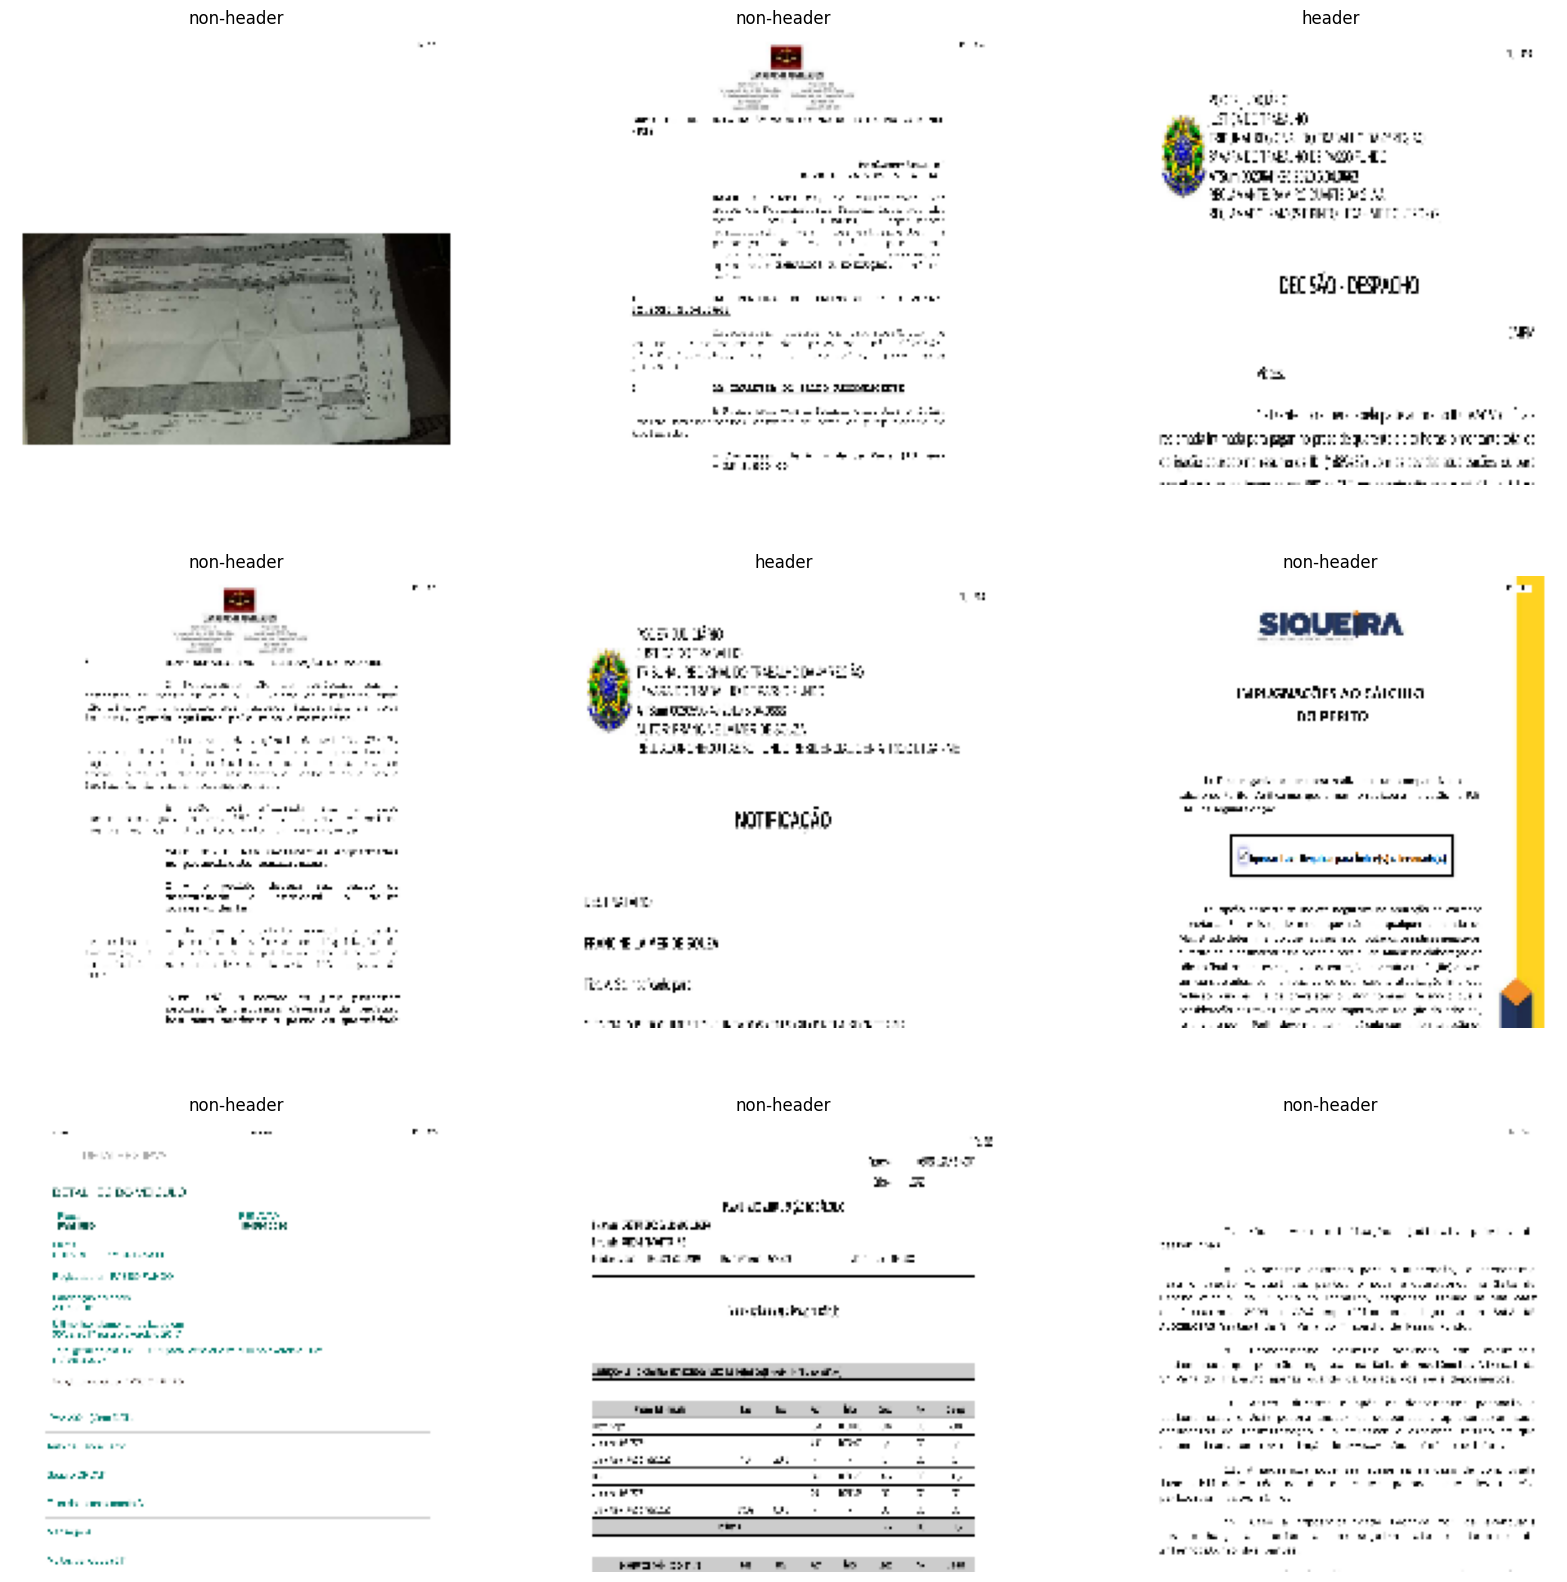

In [4]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [6]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [7]:
num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [8]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.summary()

In [9]:
# epochs=30
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [10]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
# plt.ylim([0, 1.5]) 

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.ylim([0, 1.5])
# plt.show()

In [11]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Suponha que você tenha um modelo treinado chamado 'model'
# # E você usa o conjunto de validação para fazer previsões
# y_pred = model.predict(val_ds)

# # Converta as previsões em rótulos de classe
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Obtenha os rótulos verdadeiros do conjunto de validação
# y_true = np.concatenate([y for x, y in val_ds], axis=0)

# # Calcule a matriz de confusão
# cm = confusion_matrix(y_true, y_pred_classes)

# # Visualize a matriz de confusão
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/daviga/projects/machine-learning/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-04-12 15:06:36.575529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


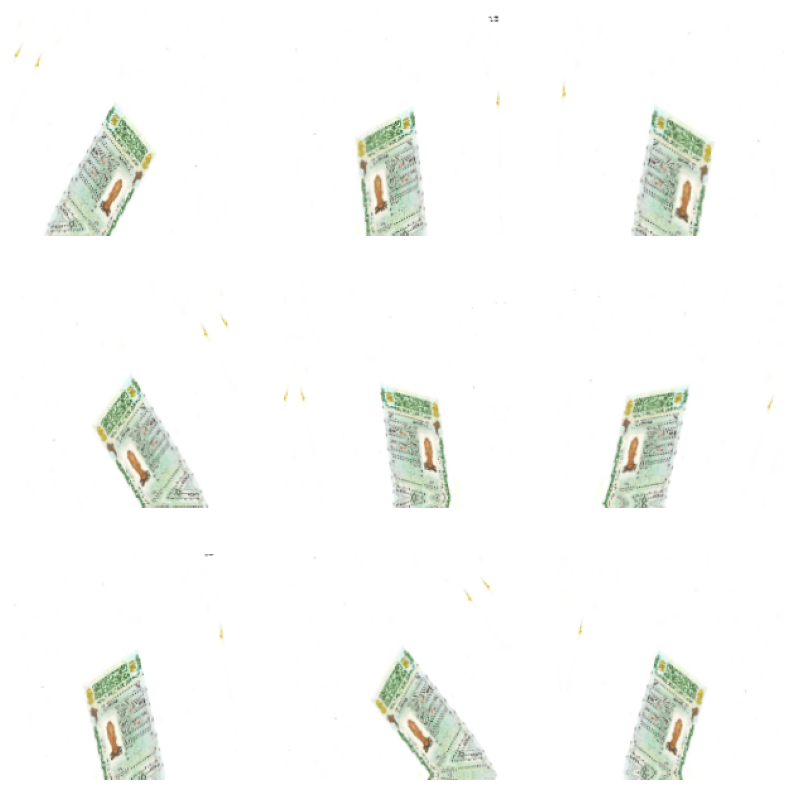

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
model = Sequential([
  layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.4870 - loss: 1.2096 - val_accuracy: 0.5337 - val_loss: 0.6778
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.5903 - loss: 0.6700 - val_accuracy: 0.7331 - val_loss: 0.6491
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.7516 - loss: 0.5045 - val_accuracy: 0.7918 - val_loss: 0.5467
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.7822 - loss: 0.4566 - val_accuracy: 0.8622 - val_loss: 0.3886
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.8549 - loss: 0.3645 - val_accuracy: 0.8680 - val_loss: 0.3400
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.8925 - loss: 0.2857 - val_accuracy: 0.8680 - val_loss: 0.3051
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8917 - loss: 0.2676 - val_accuracy: 0.8768 - val_loss: 0.2975
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9150 - loss: 0.2009 - val_accuracy: